In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

### Helper functions

In [2]:
def get_sign(ep1,ep2,c):
        vec1 = (ep1[1]-c[1]+0.000001)/(ep1[0]-c[0]+0.000001)
        vec2 = (ep2[1]-c[1]+0.000001)/(ep2[0]-c[0]+0.000001)
        return np.sign(vec1*vec2)

def distp2p(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def line(p1,p2):
    if (p1[0]-p2[0])==0:
        m = 100000
        c = 100000
    else:
        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        c = (p1[0]*p2[1]-p2[0]*p1[1])/(p1[0]-p2[0])
    return m,c

def distp2l(q,p1,p2):
    m,c = line(p1,p2)
    if m ==100000:
        x2 = p1[0]
        y2 = q[1]
    else:
        x2 = (m*q[1]-m*c+q[0])/(1+(m**2))
        y2 = ((m**2)*q[1]+m*q[0]+c)/(1+(m**2))
    q2 = np.array([x2,y2])
    return distp2p(q,q2)

def if_intersects(start,end,center,radius):
    if get_sign(end,center,start) and get_sign(start,center,end):
        if distp2l(center,start,end)<radius+0.01:
            return True
        else:
            return False
    else:
        return False

### Main Classes for RRT and RRT*

In [3]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0

class Obstacle:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

    def contains(self, node):
        return (node.x - self.x)**2 + (node.y - self.y)**2 <= self.radius**2

class RRT:
    def __init__(self, start, goal, obstacles, field_width, field_height, max_dist=0.1, max_iters=1000):
        self.start = Node(*start)
        self.goal = Node(*goal)
        # print(self.start.parent)
        self.obstacles = obstacles
        self.max_dist = max_dist
        self.max_iters = max_iters
        self.nodes = [self.start]
        self.field_width = field_width
        self.field_height = field_height

    def plan(self):
        for i in range(self.max_iters):
            q_rand = self.get_random_node()
            q_near = self.get_nearest_node(q_rand)
            q_new = self.steer(q_near, q_rand) #node to be added
            if not self.is_valid_node(q_new,q_near):
                continue
            self.nodes.append(q_new)
            q_new.parent = q_near
            # print(q_new.x,q_new.y)
            if self.is_goal_reached(q_new):
                print(True)
                return self.get_path(q_new)
        return None

    def get_random_node(self):
        if np.random.rand() < 0.05:
            # print('goal node is chosen')
            return Node(self.goal.x, self.goal.y)
        x = np.random.uniform(0, self.field_width)
        y = np.random.uniform(0, self.field_height)
        return Node(x, y)

    def get_nearest_node(self, node):
        distances = [np.sqrt((n.x - node.x)**2 + (n.y - node.y)**2) for n in self.nodes]
        return self.nodes[np.argmin(distances)]

    def steer(self, from_node, to_node):
        dist = np.sqrt((from_node.x - to_node.x)**2 + (from_node.y - to_node.y)**2)
        if dist < self.max_dist:
            return Node(to_node.x, to_node.y)
        angle = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
        x = from_node.x + self.max_dist * np.cos(angle)
        y = from_node.y + self.max_dist * np.sin(angle)
        return Node(x, y)

    def is_valid_node(self, node,from_node):
        for obs in self.obstacles:
            if obs.contains(node):
                return False
            if if_intersects([from_node.x,from_node.y],[node.x,node.y],[obs.x,obs.y],obs.radius):
                return False
        return True

    def is_goal_reached(self, node):
        return self.goal.x == node.x and self.goal.y == node.y

    def get_path(self, node):
        path = [node]
        while node.parent is not None:
            node = node.parent
            path.append(node)
        return path[::-1]

class RRT_STAR:
    def __init__(self, start, goal, obstacles, field_width, field_height, max_dist=0.1, max_iters=1000):
        self.start = Node(*start)
        self.goal = Node(*goal)
        # print(self.start.parent)
        self.obstacles = obstacles
        self.max_dist = max_dist
        self.max_iters = max_iters
        self.nodes = [self.start]
        self.field_width = field_width
        self.field_height = field_height
        self.neighbour_radius = max_dist * 2.0

    def plan(self):
        for i in range(self.max_iters):
            q_rand = self.get_random_node()
            q_near = self.get_nearest_node(q_rand)
            q_new = self.steer(q_near, q_rand) #node to be added
            if not self.is_valid_node(q_new,q_near):
                continue
            q_new = self.choose_parent(q_new, q_near)
            self.nodes.append(q_new)
            self.rewire(q_new)
            # print(q_new.x,q_new.y)
            if self.is_goal_reached(q_new):
                print(True)
                return self.get_path(q_new)
        return None

    def choose_parent(self, q_new, q_near):
        near_nodes = self.get_near_nodes(q_new)
        costs = [self.get_cost(n, q_new) for n in near_nodes if self.is_valid_node(q_new, n)]
        if len(costs) == 0:
            return q_new
        min_cost = min(costs)
        if min_cost == float('inf'):
            return q_new
        min_idx = costs.index(min_cost)
        q_new.parent = near_nodes[min_idx]
        q_new.cost = min_cost
        return q_new

    def get_near_nodes(self, q_new):
        distances = [np.sqrt((n.x - q_new.x)**2 + (n.y - q_new.y)**2) for n in self.nodes]
        return [self.nodes[i] for i in range(len(distances)) if distances[i] <= self.neighbour_radius]

    def get_cost(self, from_node, to_node):
        return from_node.cost + np.sqrt((from_node.x - to_node.x)**2 + (from_node.y - to_node.y)**2)

    def rewire(self, q_new):
        near_nodes = self.get_near_nodes(q_new)
        for node in near_nodes:
            if node == q_new.parent:
                continue
            new_cost = self.get_cost(node, q_new)
            if new_cost < node.cost and self.is_valid_node(node, q_new):
                node.parent = q_new
                node.cost = new_cost

    def get_random_node(self):
        if np.random.rand() < 0.05:
            # print('goal node is chosen')
            return Node(self.goal.x, self.goal.y)
        x = np.random.uniform(0, self.field_width)
        y = np.random.uniform(0, self.field_height)
        return Node(x, y)

    def get_nearest_node(self, node):
        distances = [np.sqrt((n.x - node.x)**2 + (n.y - node.y)**2) for n in self.nodes]
        return self.nodes[np.argmin(distances)]

    def steer(self, from_node, to_node):
        dist = np.sqrt((from_node.x - to_node.x)**2 + (from_node.y - to_node.y)**2)
        if dist < self.max_dist:
            return Node(to_node.x, to_node.y)
        angle = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
        x = from_node.x + self.max_dist * np.cos(angle)
        y = from_node.y + self.max_dist * np.sin(angle)
        return Node(x, y)

    def is_valid_node(self, node,from_node):
        for obs in self.obstacles:
            if obs.contains(node):
                return False
            if if_intersects([from_node.x,from_node.y],[node.x,node.y],[obs.x,obs.y],obs.radius):
                return False
        return True

    def is_goal_reached(self, node):
        return self.goal.x == node.x and self.goal.y == node.y

    def get_path(self, node):
        path = [node]
        while node.parent is not None:
            node = node.parent
            path.append(node)
        return path[::-1]


### Initializing the environment

Randomly generating 'n' obstacles along with start and goal in the environment

In [21]:
def plot_path(obstacles, path=None):
    fig, ax = plt.subplots(figsize=(10,8))
    for obs in obstacles:
        circle = plt.Circle((obs.x, obs.y), obs.radius, color='r')
        ax.add_artist(circle)
    if path is not None:
        xs = [node.x for node in path]
        ys = [node.y for node in path]
        plt.plot(xs, ys, color='g', linewidth=2)
    ax.set_xlim(0, field_width)
    ax.set_ylim(0, field_height)
    plt.show()

def generate_obstacles(num_obstacles, max_radius, field_width, field_height):
    obstacles = []   
    for i in range(num_obstacles):
        # Generate a random position for the obstacle
        x = np.random.uniform(0, field_width)
        y = np.random.uniform(0, field_height)
        # Generate a random radius for the obstacle
        radius = np.random.uniform(0.01, max_radius)
        # Add the obstacle to the list
        obstacles.append(Obstacle(x, y, radius))
    return obstacles

def generate_start_goal(obstacles, field_width, field_height):
    # Generate random positions for the start and goal until they do not fall into any obstacles
    while True:
        # Generate a random position for the start
        start = [np.random.uniform(0, field_width/4), np.random.uniform(0, field_height/4)]  
        # Generate a random position for the goal
        goal = [np.random.uniform(3*field_width/4,field_width), np.random.uniform(3*field_height/4,field_height)]
        
        # Check if the start and goal fall into any of the obstacles
        start_collides = any(np.sqrt((start[0] - obstacle.x)**2 + (start[1] - obstacle.y)**2) < obstacle.radius for obstacle in obstacles)
        goal_collides = any(np.sqrt((goal[0] - obstacle.x)**2 + (goal[1] - obstacle.y)**2) < obstacle.radius for obstacle in obstacles)
    
        if not start_collides and not goal_collides:
            break   
    return start, goal


### Plot for RRT

User input and parameters

In [22]:
field_width = 2
field_height = 2
number_of_obstacles = 20

obstacles = generate_obstacles(number_of_obstacles, 0.1, field_width, field_height)
start, goal = generate_start_goal(obstacles,field_width,field_height)

'''
By default obstacles are generated randomly along with the start and goal position
Uncomment below two lines to input your own obstacle and start-goal arrangement
(note this implementation only supports circular obstacles, obstacles of other shapes can be easily enclosed in a circle so as to incorporate them too!)
'''
#obstacles = [Obstacle(0.5,0.7,0.2),Obstacle(1.5,1.5,0.2)]
#start, goal = [0.1,0.1], [1.9,1.9]

print(start,goal)

[0.38817973772244796, 0.1641382498421879] [1.8171948074942135, 1.6794640502300096]


True


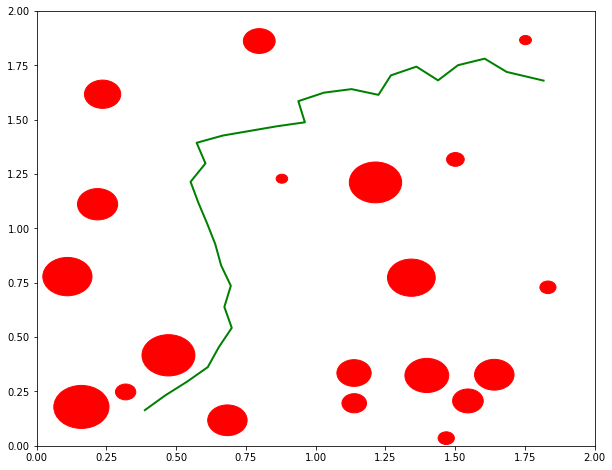

In [24]:
rrt = RRT(start, goal, obstacles, field_width, field_height)
path = rrt.plan()
plot_path(obstacles, path)

### Plot for RRT*

True


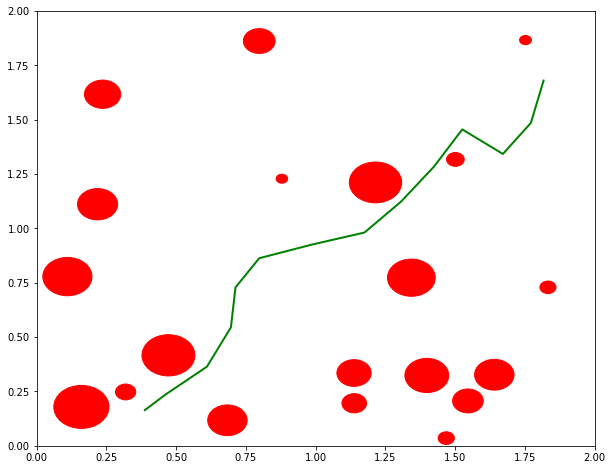

In [40]:
rrt_star = RRT_STAR(start, goal, obstacles, field_width, field_height)
path_star = rrt_star.plan()
plot_path(obstacles, path_star)